## Exercise 2

Example solution provided by Tania Kozynets (AMAS-2021 TA), Feb. 15, 2021; see alternative solutions by [Niccolo](https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2021/Exercises/Lecture3_likelihood_niccolo.py) (AMAS-2017 TA) and [Jean-Loup](https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2021/Exercises/Lecture3_Exercises2-3.ipynb) (AMAS-2019 TA).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools
from scipy.optimize import minimize 

### My pretty plotting routines

In [2]:
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)


### Defining the likelihood function

In [3]:
def likelihood(x,alpha,beta):
    #we will transform this into a PDF right away...
    pdf = 1+alpha*x+beta*x**2
    #...remembering the PDF should be normalized! this is the definite integral over range -1..1
    norm = 2+(2*beta/3)
    #return the evaluated PDF only inside -1..1 range, and 0 outside
    return np.where(np.abs(x) <= 1, pdf/norm, 0.)

def log_likelihood(x,alpha,beta):
    #The log-likelihood to get all of the x-points (together) given our custom PDF with parameters alpha and beta.
    return np.sum(np.log(likelihood(x,alpha,beta)),axis=1)


### Sampling using the accept-reject method

In [4]:
#true parameters of our PDF
true_alpha = 0.5
true_beta = 0.5

num_samples = 5000

#We will define a simple linear space in x and evaluate the PDF over this range.
xrange = np.linspace(-1,1,100)
pdf_curve = likelihood(xrange,true_alpha,true_beta)

#Next, we will find where the PDF evaluated on xrange has its maximum.
#This will be our upper boundary for the accept-reject box; the lower boundary is 0.
max_value = np.max(pdf_curve)
min_value = 0

#We sample uniformly from both x and the "pdf" (in reality just a variable that goes along the y-axis) to 
#populate the accept-reject box.
x_samples = np.random.uniform(-1,1,num_samples)
pdf_samples = np.random.uniform(min_value,max_value,num_samples)

#Then, we will actually evaluate the PDFs at our x_samples given the likelihood function we defined.
evaluated_pdfs_at_x = likelihood(x_samples,true_alpha,true_beta)
#The accept-reject test will be passed if our "pdf samples" are below the actual PDF.
accept_inds = np.where(evaluated_pdfs_at_x - pdf_samples > 0)[0]
reject_inds = np.where(evaluated_pdfs_at_x - pdf_samples < 0)[0]

### Plotting the Monte Carlo samples

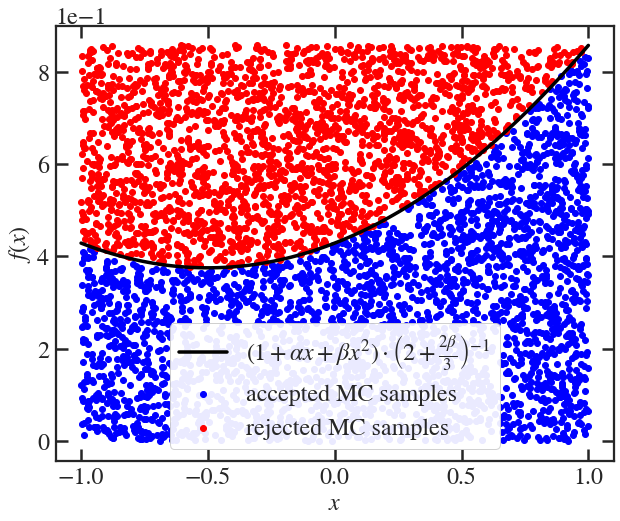

In [5]:
reset_plt(24,24)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)

ax.scatter(x_samples[accept_inds],pdf_samples[accept_inds],color='blue',label = 'accepted MC samples')
ax.scatter(x_samples[reject_inds],pdf_samples[reject_inds],color='red', label = 'rejected MC samples')
ax.plot(xrange,pdf_curve, ls = '-', color = 'black', lw = 3.5, 
        label = r'$(1 + \alpha x + \beta x^2)\cdot \left(2 + \frac{2\beta}{3}\right)^{-1}$')

put_ticks(fig,ax)
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

ax.legend(loc = 'lower center',frameon = True, framealpha = 0.92)


### Histogramming the Monte Carlo samples



Text(0, 0.5, '$f(x)$')

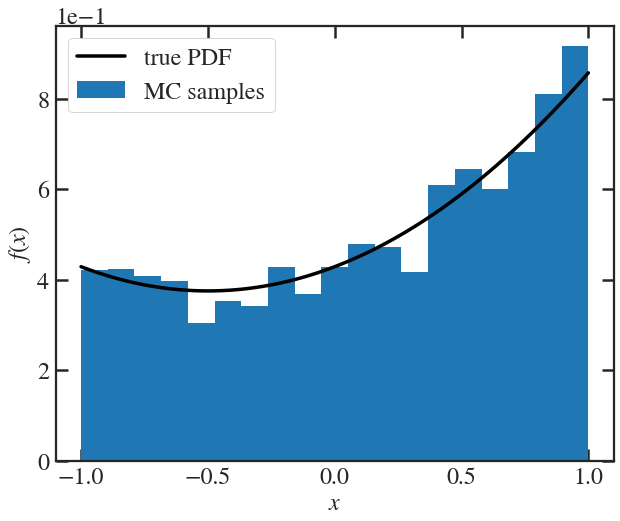

In [6]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
#we will be displaying the normalized histogram (density = True)...
ax.hist(x_samples[accept_inds],bins=np.linspace(-1,1,20),density=True,label = 'MC samples')

#...so that we can (again) plot the normalized the PDF on top of it:
ax.plot(xrange,pdf_curve, ls = '-', color = 'black', lw = 3.5, 
        label = r'true PDF')

ax.legend(loc = 'upper left',frameon = True)
put_ticks(fig,ax)
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

### Fitting for $\alpha$ and $\beta$


First, we will define the function that computes the negative log likelihood of observing our MC samples given some assumed parameters $\alpha$ and $\beta$. These appear as **params[0]** and **params[1]** below, respectively. This is done because [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) (which we will choose as our minimizer here) expects a vector of parameters as an input, rather than two scalars separately.


In [7]:
lambda_neg_LLH = lambda params: -log_likelihood(x_samples[accept_inds],
                                np.expand_dims([params[0]],axis=1),np.expand_dims([params[1]],axis=1))
#notice some broadcasting tricks above, which let us operate on vector-like x-samples as well as vector-like
#parameters alpha and beta. This is no different from what we've done in Exercise 1.

Next, we move to the actual minimization of the -LLH function. We need to pass a seed to the minimizer, which (given the truth of [0.5,0.5] we put to be [0.3,0.3] here.

In [8]:
res = minimize(lambda_neg_LLH,x0=[0.3,0.3],bounds=((-0.2,1),(0,1)),method='L-BFGS-B')
res

      fun: array([1887.57735776])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.        , 0.00022737])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([0.56705708, 0.68664904])

Now, **res.x** contains the estimate of $\alpha$ and $\beta$ that **scipy.optimize.minimize** gave us.  What about the errors? Since we were minimizing the negative LLH, the inverse Hessian matrix returned by the fit (**res.hess_inv**) is the covariance matrix describing a gaussian approximation to the MLE (see more on [Stackexchange](https://stackoverflow.com/questions/43593592/errors-to-fit-parameters-of-scipy-optimize)). This means that we can compute the uncertainties as simply as:

In [9]:
errors = np.sqrt(np.diag(res.hess_inv.todense()))
errors

array([0.04707429, 0.11234037])

A different set of 2,000 Monte Carlo samples may give different answers for both best-fit values of the parameters and their errors. Sometimes it may not even converge! 

Feel free to explore for that depends on the initial guess, the bounds, the method of minimization, and remember that it should become more stable with more MC samples. Increase their number to 5,000 or 10,000 if in doubt.

## Exercise 3

### Regenerating the MC


Since we might have to do this again, here's a convenient function that goes through the accept-reject procedure and returns the samples and their PDF given a set of true $\alpha$ and $\beta$.

In [10]:
def gen_MC(alpha,beta,_num_samples):
    
    #true parameters of our PDF
    true_alpha = alpha
    true_beta = beta

    #We will define a simple linear space in x and evaluate the PDF over this range.
    xrange = np.linspace(-1,1,100)
    pdf_curve = likelihood(xrange,alpha,beta)

    #Next, we will find where the PDF evaluated on xrange has its maximum.
    #This will be our upper boundary for the accept-reject box; the lower boundary is 0.
    max_value = np.max(pdf_curve)
    min_value = 0

    #We sample uniformly from both x and the "pdf" (in reality just a variable that goes along the y-axis) to 
    #populate the accept-reject box.
    x_samples = np.random.uniform(-1,1,_num_samples)
    pdf_samples = np.random.uniform(min_value,max_value,_num_samples)

    #Then, we will actually evaluate the PDFs at our x_samples given the likelihood function we defined.
    evaluated_pdfs_at_x = likelihood(x_samples,alpha,beta)
    #The accept-reject test will be passed if our "pdf samples" are below the actual PDF.
    accept_inds = np.where(evaluated_pdfs_at_x - pdf_samples > 0)[0]
    reject_inds = np.where(evaluated_pdfs_at_x - pdf_samples < 0)[0]
    
    return x_samples[accept_inds],pdf_curve

Putting our generator to use:

In [11]:
new_true_alpha = 0.6
new_true_beta = 0.5
generated_samples,generated_pdf = gen_MC(alpha=new_true_alpha,beta=new_true_beta,_num_samples=num_samples)

Performing the grid scan given the new MC:

In [12]:
alpha_range = np.linspace(-0.2,1,100)
beta_range = np.linspace(0,1,100)

alpha_beta_pairs = np.array(list(itertools.product(alpha_range,beta_range)))
alphas_from_grid = np.expand_dims(alpha_beta_pairs[:,0],axis=1)
betas_from_grid = np.expand_dims(alpha_beta_pairs[:,1],axis=1)

scanned_llh = log_likelihood(generated_samples,alphas_from_grid,betas_from_grid)

Running the minimizer once again (remember that we changed the truth!):

In [13]:
lambda_neg_LLH = lambda params: -log_likelihood(generated_samples,
                                np.expand_dims([params[0]],axis=1),np.expand_dims([params[1]],axis=1))

res = minimize(lambda_neg_LLH,x0=[0.3,0.3],bounds=((-0.2,1),(0,1)),method='L-BFGS-B')
res

      fun: array([1766.92363985])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.82121023e-05,  2.27373674e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([0.6079417 , 0.51968747])

### Visualizing the likelihood landscape

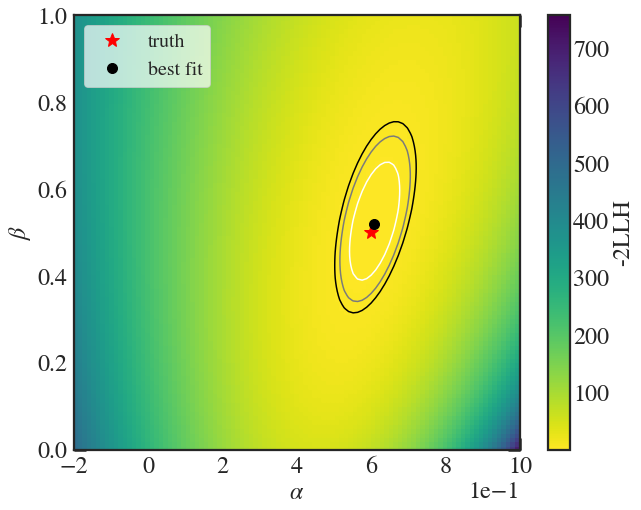

In [14]:
reset_plt(24,24)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)

#raster scan results
sc = ax.scatter(alphas_from_grid,betas_from_grid,c=-2*(scanned_llh+res.fun),
               marker = 's', s = 100, cmap = 'viridis_r')

#the truth
ax.plot(new_true_alpha,new_true_beta,marker='*',color='red',markersize=15,ls='none', 
       label = 'truth')

#the minimizer results: best-fitting alpha,beta parameters
ax.plot(res.x[0],res.x[1],marker='o',color='black',markersize=10,ls='none', 
       label = 'best fit')

#Extra: plotting the contrours of constant -2*deltaLLH = [2.3,4.5,6]. Do you know why this choice of values? :)

contours = ax.contour(alphas_from_grid.reshape(len(alpha_range),len(beta_range)),
           betas_from_grid.reshape(len(alpha_range),len(beta_range)),
          -2*(scanned_llh+res.fun).reshape(len(alpha_range),len(beta_range)),
           [2.3,4.5,6])


ax.legend(loc = 'upper left', fontsize = 20,framealpha=0.7,frameon=True)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')

cb = fig.colorbar(sc,label=r'-2LLH')
put_ticks(fig,ax)
